In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
from os.path import join
import cv2
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, '../utils')

from display_images import browse_images, show_images_batch
from preprocessing import TransformRandomCrop, TransformRescale, TransformToTensor, TransformGreyScale
from drivers_dataset import load_data_references, split_refs_df, DriversDataset, split_refs_df_by_subject
from custom_model import CustomModel, ConvNet2

import os

In [2]:
DATA_PATH = '../data/'
IMGS_TRAIN_FOLDER = DATA_PATH + 'imgs/train'
IMGS_TEST_FOLDER = DATA_PATH + 'imgs/test'
AJAX_TEST_FOLDER = DATA_PATH + 'imgs/ajax_test'
REFS_PATH = DATA_PATH + 'driver_imgs_list.csv'
AJAX_REFS_PATH = DATA_PATH + 'ajax_imgs_list.csv'
TEST_REFS_PATH = DATA_PATH + 'test_imgs_list.csv'
MODELS_PATH = '../models_saved/'
LOGS_PATH = '../runs/'

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)
    
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
WORKERS = 8 if DEVICE == torch.device("cuda") else 0

print(WORKERS)

print("GPU is available") if DEVICE == torch.device("cuda") else print("No GPU :(")

8
GPU is available


# 2.BUILD MODELS

In [ ]:
from math import floor
from datetime import datetime
# Training function

# helper functions
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted classajax_refs_pa
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [el[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    targets_map = {0: "normal driving", 1: "texting - right", 2: "talking on the phone - right", 3:"texting - left", 4:"talking on the phone - left", 5:"operating the radio", 6:"drinking", 7:"reaching behind", 8:"hair and makeup", 9:"talking to passenger"}
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(24, 24))
    for idx in np.arange(len(images)):
        ax = fig.add_subplot(1, len(images), idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            targets_map[preds[idx]],
            probs[idx] * 100.0,
            targets_map[labels[idx].item()]),
            color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def computeAccuracies(model, data_loader, device = torch.device("cpu"), total_accuracy_only = False):

    # Compute accuracies
    targets_map = {0: "normal driving", 1: "texting - right", 2: "talking on the phone - right", 3:"texting - left", 4:"talking on the phone - left", 5:"operating the radio", 6:"drinking", 7:"reaching behind", 8:"hair and makeup", 9:"talking to passenger"}

    accuracies = {}
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(targets_map)))
    class_total = list(0. for i in range(len(targets_map)))
    model.to(device)
    
    with torch.no_grad():
        for batch in data_loader:
            images = batch['image']
            if len(images.shape) == 3 : images.unsqueeze_(1)
            labels = batch['target']
            images, labels = images.float().to(device), labels.to(device)
            
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if not total_accuracy_only:
                c = (predicted == labels).squeeze()
                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
                    
    accuracies["total_accuracy"] = 100 * correct / total
    if not total_accuracy_only:
        for i in range(len(class_correct)):
            key = f"{targets_map[i]}_accuracy"
            accuracies[key] =  100 * class_correct[i]/class_total[i] if class_total[i] else -1
    return accuracies


def train(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs = 2, device=torch.device("cpu"), verbose = 1):

    start_time = datetime.now().replace(microsecond=0)
    log_period = floor(max(len(train_loader) / 20, 1)) if verbose > 0 else 1000
    running_loss = 0.0
    
    print("Training started - batches:({}TRAIN | {}VAL | {}TEST), {} epochs; batch size: {}; learning rate: {}".format(len(train_loader), len(val_loader), len(test_loader), epochs, train_loader.batch_size, optimizer.defaults["lr"]))
    model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, batch in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images = batch['image']
            if len(images.shape) == 3 : images.unsqueeze_(1)
            labels = batch['target']
            images, labels = images.float().to(device), labels.to(device)

            # forward + backward + optimize
            model.train()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            # print statistics
            new_loss = loss.item()
            running_loss += new_loss
            
            if i % log_period == log_period - 1:
                elapsed = datetime.now().replace(microsecond=0) - start_time
                print('[Elapsed: {} epoch {}/{}, batch {}/{}] train_loss: {}'.format(elapsed, epoch + 1, epochs, i + 1, len(train_loader), round(running_loss/log_period, 5)))
                
                # ...log the running loss
                writer.add_scalar('train loss', running_loss / log_period, epoch * len(train_loader) + i)
                running_loss = 0.0
                
        val_accuracies = computeAccuracies(model, val_loader, device = device, total_accuracy_only = False)
        print('--- Epoch {} : Val Accuracies (%): {}'.format(epoch + 1, val_accuracies))
        writer.add_scalars('Val Accuracies', val_accuracies, global_step=epoch + 1)
    test_accuracies = computeAccuracies(model, test_loader, device = device, total_accuracy_only = False)
    writer.close()
    print('Finished Training !!')


def eval_model(model, criterion, optimizer, test_loader, device=torch.device("cpu"), verbose = 1):
    start_time = datetime.now().replace(microsecond=0)
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, batch in enumerate(test_loader, 0):
        if i % 8 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)
        # get the inputs
        images = batch['image']
        if len(images.shape) == 3 : images.unsqueeze_(1)
        labels = batch['target']
        images, labels = images.float().to(device), labels.to(device)

        # forward + backward + optimize
        model.eval()
        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += (torch.sum(preds == labels.data)).item()
        del images, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / test_batches
    avg_acc = acc_test / test_batches
    
    elapsed_time = datetime.now().replace(microsecond=0) - start_time
    print()
    print("Evaluation completed in {}".format(elapsed_time))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
architectures = [None, None, None]

In [ ]:
MODEL_NAME = 'CNN_PROFOND_BATCHNORM'

architecture = [
    'conv2d_32_3_1', 'relu', 'batchnorm2d',
    'conv2d_32_3_1', 'relu', 'batchnorm2d', 'maxpool2d_2',
    'dropout_0.3',
    'conv2d_64_3_1', 'relu', 'batchnorm2d',
    'conv2d_64_3_1', 'relu', 'batchnorm2d', 'maxpool2d_2',
    'dropout_0.3',
    'conv2d_128_3_1', 'relu', 'batchnorm2d',
    'conv2d_128_3_1', 'relu', 'batchnorm2d', 'maxpool2d_2',
    'dropout_0.5',
    'flatten',
    'dense_512', 'relu', 'batchnorm1d',
    'dense_128', 'relu', 'dropout_0.25',
    'dense_10', 'softmax_1',
]

SPLIT_RANDOM_STATE = 42
SPLIT_TRAIN_FRACTION = 0.8 # Proportion of train set amongst whole dataset (train / total)
VAL_PROP = 0.1 # Proportion among the train set (val / train)

EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MOMENTUM = 0.1

df_dataset = load_data_references(REFS_PATH, IMGS_TRAIN_FOLDER)

preprocessing = transforms.Compose([
        TransformGreyScale(),
        TransformRescale((64, 64)), # x(3/10) (/ORIGINAL SIZE IS (480, 640)
        #TransformRandomCrop((140, 140)),
        TransformToTensor()
])

data_sample = DriversDataset(refs_df = df_dataset.iloc[:2], images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
loader_sample = DataLoader(data_sample, batch_size=1, pin_memory=True, num_workers=WORKERS)
image_sample = next(iter(loader_sample))['image']
input_shape = image_sample[0].shape
model = CustomModel(architecture, input_shape)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


architectures[0] = {'name' : MODEL_NAME, 'model' : model, 'preprocessing' : preprocessing, 'criterion': criterion, 'optimizer': optimizer, 'image_sample' : image_sample}
print('Model {} Ready ({} trainable parameters) !'.format(MODEL_NAME, sum(p.numel() for p in model.parameters() if p.requires_grad)))

In [ ]:
MODEL_NAME = 'CNN_BASELINE'
architecture = [
    'conv2d_64_3_1', 'relu', 'maxpool2d_2',
    'conv2d_128_3_1', 'relu', 'maxpool2d_2',
    'conv2d_256_3_1', 'relu', 'maxpool2d_2',
    'conv2d_512_3_1', 'relu', 'maxpool2d_2',
    'dropout_0.5',
    'flatten',
    'dense_500', 'relu',
    'dropout_0.5',
    'dense_10', 'softmax_1',
]


SPLIT_RANDOM_STATE = 42
SPLIT_TRAIN_FRACTION = 0.8 # Proportion of train set amongst whole dataset (train / total)
VAL_PROP = 0.1 # Proportion among the train set (val / train)

EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MOMENTUM = 0.1

df_dataset = load_data_references(REFS_PATH, IMGS_TRAIN_FOLDER)

preprocessing = transforms.Compose([
        TransformGreyScale(),
        TransformRescale((64, 64)), # x(3/10) (/ORIGINAL SIZE IS (480, 640)
        #TransformRandomCrop((140, 140)),
        TransformToTensor()
])

data_sample = DriversDataset(refs_df = df_dataset.iloc[:2], images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
loader_sample = DataLoader(data_sample, batch_size=1, pin_memory=True, num_workers=WORKERS)
image_sample = next(iter(loader_sample))['image']
input_shape = image_sample[0].shape
model = CustomModel(architecture, input_shape)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

architectures[1] = {'name' : MODEL_NAME, 'model' : model, 'preprocessing' : preprocessing, 'criterion': criterion, 'optimizer': optimizer , 'image_sample' : image_sample}
print('Model {} Ready ({} trainable parameters) !'.format(MODEL_NAME, sum(p.numel() for p in model.parameters() if p.requires_grad)))

In [ ]:
MODEL_NAME = 'CNN_BASELINE_WITHOUT_PREPROCESSING'

architecture = [
    'conv2d_64_3_1', 'relu', 'maxpool2d_2',
    'conv2d_128_3_1', 'relu', 'maxpool2d_2',
    'conv2d_256_3_1', 'relu', 'maxpool2d_2',
    'conv2d_512_3_1', 'relu', 'maxpool2d_2',
    'dropout_0.5',
    'flatten',
    'dense_500', 'relu',
    'dropout_0.5',
    'dense_10', 'softmax_1',
]


SPLIT_RANDOM_STATE = 42
SPLIT_TRAIN_FRACTION = 0.8 # Proportion of train set amongst whole dataset (train / total)
VAL_PROP = 0.1 # Proportion among the train set (val / train)


EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MOMENTUM = 0.1

df_dataset = load_data_references(REFS_PATH, IMGS_TRAIN_FOLDER)


preprocessing = transforms.Compose([
        TransformRescale((64, 64)), # x(3/10) (/ORIGINAL SIZE IS (480, 640)
        #TransformRandomCrop((140, 140)),
        TransformToTensor()
])

data_sample = DriversDataset(refs_df = df_dataset.iloc[:2], images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
loader_sample = DataLoader(data_sample, batch_size=1, pin_memory=True, num_workers=WORKERS)
image_sample = next(iter(loader_sample))['image']
input_shape = image_sample[0].shape

model = CustomModel(architecture, input_shape)
model.to(DEVICE)
# model = ConvNet2()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

architectures[2] = {'name' : MODEL_NAME, 'model' : model, 'preprocessing' : preprocessing, 'criterion': criterion, 'optimizer': optimizer, 'image_sample' : image_sample }
print('Model {} Ready ({} trainable parameters) !'.format(MODEL_NAME, sum(p.numel() for p in model.parameters() if p.requires_grad)))

In [ ]:
df_train_val_set, df_test_set = split_refs_df_by_subject(df_dataset, split_fraction=SPLIT_TRAIN_FRACTION, random_state = SPLIT_RANDOM_STATE)
df_val_set, df_train_set = split_refs_df_by_subject(df_train_val_set, split_fraction=VAL_PROP, random_state = SPLIT_RANDOM_STATE)

train_set = DriversDataset(refs_df = df_train_set, images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
val_set = DriversDataset(refs_df = df_val_set, images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
test_set = DriversDataset(refs_df = df_test_set, images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=WORKERS)


In [ ]:
for architecture in architectures[2:3] :

    writer = SummaryWriter('../runs/{}_{}_training'.format(datetime.now().strftime('%m-%d_%H:%M'), architecture['name']))
    writer.add_graph(architecture['model'], architecture['image_sample'].float().to(DEVICE))

    train(architecture['model'], architecture['criterion'], architecture['optimizer'], train_loader, val_loader, test_loader, epochs = EPOCHS, device = DEVICE, verbose = 1)

In [ ]:
path_model =  f"{MODELS_PATH}{datetime.now().strftime('%m-%d_%H-%M')}_{architectures[0]['name']}.pth"
torch.save(architectures[0]['model'].state_dict(), path_model)
params = {
    'architecture': architecture,
    'input_shape': input_shape,
    'MODEL_NAME': architectures[0]['name'],
    'EPOCHS': EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'LEARNING_RATE': LEARNING_RATE,
    'MOMENTUM': MOMENTUM,
    'SPLIT_RANDOM_STATE': SPLIT_RANDOM_STATE,
    'SPLIT_TRAIN_FRACTION': SPLIT_TRAIN_FRACTION
    
}
path_params =  f"{MODELS_PATH}{datetime.now().strftime('%m-%d_%H-%M')}_{architectures[0]['name']}_params.npy"
np.save(path_params, params)

In [ ]:
path_params = f"{MODELS_PATH}03-01_17-13_CNN_PROFOND_BATCHNORM_params.npy"
path_model = f"{MODELS_PATH}03-01_17-13_CNN_PROFOND_BATCHNORM.pth"
previous_model_params = np.load(path_params, allow_pickle=True)
previous_model = CustomModel(previous_model_params.item()['architecture'], previous_model_params.item()['input_shape'])
previous_model.load_state_dict(torch.load(path_model))
previous_model.to(DEVICE)

In [ ]:
leaked_path_params = f"{MODELS_PATH}02-29_15-18_CNN_PROFOND_BATCHNORM_params.npy"
leaked_path_model = f"{MODELS_PATH}02-29_15-18_CNN_PROFOND_BATCHNORM.pth"
leaked_model_params = np.load(path_params, allow_pickle=True)
leaked_model = CustomModel(leaked_model_params.item()['architecture'], leaked_model_params.item()['input_shape'])
leaked_model.load_state_dict(torch.load(path_model))
leaked_model.to(DEVICE)

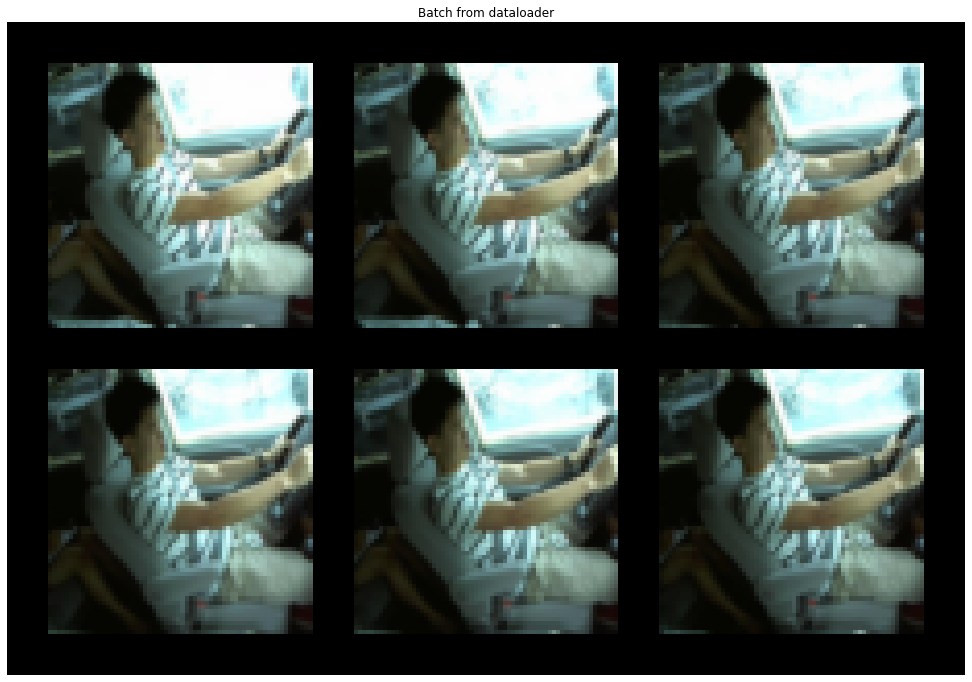

In [4]:
df_ajax_test = load_data_references(AJAX_REFS_PATH, AJAX_TEST_FOLDER)

df_dataset = load_data_references(REFS_PATH, IMGS_TRAIN_FOLDER)

df_test = load_data_references(TEST_REFS_PATH, IMGS_TEST_FOLDER)

preprocessing = transforms.Compose([
        TransformRescale((64, 64)), # x(3/10) (/ORIGINAL SIZE IS (480, 640)
        #TransformRandomCrop((140, 140)),
        TransformToTensor()
])

targets_map = {0: "normal driving", 1: "texting - right", 2: "talking on the phone - right", 3:"texting - left", 4:"talking on the phone - left", 5:"operating the radio", 6:"drinking", 7:"reaching behind", 8:"hair and makeup", 9:"talking to passenger"}

data_sample = DriversDataset(refs_df = df_ajax_test, images_dir = AJAX_TEST_FOLDER, transform = preprocessing)
loader_sample = DataLoader(data_sample, batch_size=3, pin_memory=True, num_workers=WORKERS)
sample_batch = next(iter(loader_sample))

other_data_sample = DriversDataset(refs_df = df_dataset, images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
other_loader_sample = DataLoader(other_data_sample, batch_size=6, pin_memory=True, shuffle=False, num_workers=WORKERS)
other_sample_batch = next(iter(other_loader_sample))

test_data_sample = DriversDataset(refs_df = df_test, images_dir = IMGS_TEST_FOLDER, transform = preprocessing)
test_loader_sample = DataLoader(test_data_sample, batch_size=4, pin_memory=True, num_workers=WORKERS)
test_sample_batch = next(iter(test_loader_sample)) 

#images, labels = sample_batch['image'].float().to(DEVICE), sample_batch['target'].float().to(DEVICE)
images, labels = other_sample_batch['image'].float().to(DEVICE), other_sample_batch['target'].float()
#images, labels = test_sample_batch['image'].float().to(DEVICE), test_sample_batch['target'].float().to(DEVICE)

# previous_model.eval()
# leaked_model.eval()


# output = previous_model(images)

# _, preds_tensor = torch.max(output, 1)
# preds = np.squeeze(preds_tensor.cpu().numpy())


# plot_classes_preds(previous_model, images, labels)
# plot_classes_preds(leaked_model, images, labels)

show_images_batch(other_sample_batch)









In [ ]:
# print(all_labels)
# print(all_preds)

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# cm = confusion_matrix(all_labels, all_preds)

# df_cm = pd.DataFrame(cm, range(10), range(10))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

# plt.show()

In [ ]:
MODEL_NAME = 'VGG'

SPLIT_RANDOM_STATE = 42
SPLIT_TRAIN_FRACTION = 0.8 # Proportion of train set amongst whole dataset (train / total)
VAL_PROP = 0.1 # Proportion among the train set (val / train)


EPOCHS = 15
BATCH_SIZE = 256
LEARNING_RATE = 0.0005
MOMENTUM = 0.9

df_dataset = load_data_references(REFS_PATH, IMGS_TRAIN_FOLDER)


preprocessing = transforms.Compose([
        TransformRescale((64, 64)), # x(3/10) (/ORIGINAL SIZE IS (480, 640)
        #TransformRandomCrop((140, 140)),
        TransformToTensor()
])

data_sample = DriversDataset(refs_df = df_dataset.iloc[:2], images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
loader_sample = DataLoader(data_sample, batch_size=1, pin_memory=True, num_workers=WORKERS)
input_shape = next(iter(loader_sample))['image'][0].shape


vgg16 = models.vgg16_bn(pretrained=True)
#vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 10)]) # Add our layer with 10 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
vgg16.to(DEVICE)
print(vgg16)


from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

print('Model {} Ready ({} trainable parameters) !'.format(MODEL_NAME, sum(p.numel() for p in vgg16.parameters() if p.requires_grad)))

In [ ]:
df_train_val_set, df_test_set = split_refs_df_by_subject(df_dataset, split_fraction=SPLIT_TRAIN_FRACTION, random_state = SPLIT_RANDOM_STATE)
df_val_set, df_train_set = split_refs_df_by_subject(df_train_val_set, split_fraction=VAL_PROP, random_state = SPLIT_RANDOM_STATE)

train_set = DriversDataset(refs_df = df_train_set, images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
val_set = DriversDataset(refs_df = df_val_set, images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)
test_set = DriversDataset(refs_df = df_test_set, images_dir = IMGS_TRAIN_FOLDER, transform = preprocessing)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=WORKERS)

df_train_set.groupby('classname')['img'].count().plot(kind='bar')

In [ ]:
eval_model(vgg16, criterion, optimizer, test_loader, device=DEVICE)

In [ ]:
writer = SummaryWriter('../runs/{}_{}_training'.format(datetime.now().strftime('%m-%d_%H:%M'), MODEL_NAME))
train(vgg16, criterion, optimizer, train_loader, val_loader, test_loader, epochs = EPOCHS, device = DEVICE, verbose = 1)